
---

## Objectives
1. Extract joint angles from 3D skeleton data
2. Calculate distance and proportion features
3. Create symmetry and balance features
4. Apply feature selection techniques
5. Validate feature relevance for physiotherapy

---

In [ ]:
#  Import libraries and load preprocessed data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from tqdm import tqdm
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


sys.path.append('../../src')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Setup paths
PROCESSED_PATH = Path("../../data/processed")
FIGURES_PATH = Path("../../results/figures/feature_analysis")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Load preprocessed data
print("Loading preprocessed data...")
X_train = np.load(PROCESSED_PATH / 'X_train.npy')
X_test = np.load(PROCESSED_PATH / 'X_test.npy')
y_train = np.load(PROCESSED_PATH / 'y_train_position.npy')
y_test = np.load(PROCESSED_PATH / 'y_test_position.npy')
train_metadata = pd.read_csv(PROCESSED_PATH / 'train_metadata.csv')
test_metadata = pd.read_csv(PROCESSED_PATH / 'test_metadata.csv')

print(f"✓ Loaded training data: {X_train.shape}")
print(f"✓ Loaded test data: {X_test.shape}")
print(f"✓ Sequence length: {X_train.shape[1]} frames")
print(f"✓ Features per frame: {X_train.shape[2]}")


JOINT_NAMES = [
    'SpineBase', 'SpineMid', 'Neck', 'Head', 'ShoulderLeft',
    'ElbowLeft', 'WristLeft', 'HandLeft', 'ShoulderRight', 'ElbowRight',
    'WristRight', 'HandRight', 'HipLeft', 'KneeLeft', 'AnkleLeft',
    'FootLeft', 'HipRight', 'KneeRight', 'AnkleRight', 'FootRight',
    'SpineShoulder', 'HandTipLeft', 'ThumbLeft', 'HandTipRight', 'ThumbRight'
]

# Check position distribution
print("\nPosition distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for pos, count in zip(unique, counts):
    print(f"  {pos}: {count} ({count/len(y_train)*100:.1f}%)")

Loading preprocessed data...
✓ Loaded training data: (2061, 100, 75)
✓ Loaded test data: (516, 100, 75)
✓ Sequence length: 100 frames
✓ Features per frame: 75

Position distribution in training set:
  Sitting: 1048 (50.8%)
  Standing: 972 (47.2%)
  Unknown: 41 (2.0%)


In [ ]:
#  Extract statistical features from temporal sequences
def extract_statistical_features(X):
    """
    Extract statistical features from each sequence
    For each of the 75 coordinates, extract:
    - Mean, Median, Std, Min, Max, Range, Skewness, Kurtosis
    """
    n_samples = X.shape[0]
    n_coords = X.shape[2]  # 75 coordinates
    n_stats = 8  # number of statistical features
    
    features = np.zeros((n_samples, n_coords * n_stats))
    
    print(f"Extracting statistical features for {n_samples} samples...")
    for i in tqdm(range(n_samples), desc="Processing samples"):
        sequence = X[i]  # Shape: (100, 75)
        
        for coord_idx in range(n_coords):
            coord_data = sequence[:, coord_idx]
            
            # Calculate statistics
            base_idx = coord_idx * n_stats
            features[i, base_idx + 0] = np.mean(coord_data)
            features[i, base_idx + 1] = np.median(coord_data)
            features[i, base_idx + 2] = np.std(coord_data)
            features[i, base_idx + 3] = np.min(coord_data)
            features[i, base_idx + 4] = np.max(coord_data)
            features[i, base_idx + 5] = np.max(coord_data) - np.min(coord_data)  # Range
            features[i, base_idx + 6] = stats.skew(coord_data)
            features[i, base_idx + 7] = stats.kurtosis(coord_data)
    
    return features

# Extract statistical features
print("Extracting statistical features from training data...")
X_train_stats = extract_statistical_features(X_train)
print(f"✓ Training statistical features shape: {X_train_stats.shape}")

print("\nExtracting statistical features from test data...")
X_test_stats = extract_statistical_features(X_test)
print(f"✓ Test statistical features shape: {X_test_stats.shape}")

# Create feature names
stat_feature_names = []
stat_types = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
for joint_idx in range(25):
    for coord in ['x', 'y', 'z']:
        for stat_type in stat_types:
            stat_feature_names.append(f"{JOINT_NAMES[joint_idx]}_{coord}_{stat_type}")

print(f"\nTotal statistical features: {len(stat_feature_names)}")
print(f"First 10 feature names: {stat_feature_names[:10]}")

Extracting statistical features from training data...
Extracting statistical features for 2061 samples...


Processing samples: 100%|██████████| 2061/2061 [00:44<00:00, 46.78it/s]


✓ Training statistical features shape: (2061, 600)

Extracting statistical features from test data...
Extracting statistical features for 516 samples...


Processing samples: 100%|██████████| 516/516 [00:10<00:00, 47.04it/s]

✓ Test statistical features shape: (516, 600)

Total statistical features: 600
First 10 feature names: ['SpineBase_x_mean', 'SpineBase_x_median', 'SpineBase_x_std', 'SpineBase_x_min', 'SpineBase_x_max', 'SpineBase_x_range', 'SpineBase_x_skew', 'SpineBase_x_kurtosis', 'SpineBase_y_mean', 'SpineBase_y_median']


In [ ]:
# Extract biomechanical features
def calculate_joint_angle(p1, p2, p3):
    """
    Calculate angle between three points (in degrees)
    p2 is the vertex of the angle
    """
    v1 = p1 - p2
    v2 = p3 - p2
    
    # Calculate angle using dot product
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    cos_angle = np.clip(cos_angle, -1, 1)  # Ensure valid range
    angle = np.arccos(cos_angle)
    
    return np.degrees(angle)

def extract_biomechanical_features(X):
    """
    Extract biomechanically relevant features:
    - Key joint angles (hip, knee, ankle, elbow, shoulder)
    - Center of mass
    - Postural sway
    - Body symmetry measures
    """
    n_samples = X.shape[0]
    features = []
    
    print(f"Extracting biomechanical features for {n_samples} samples...")
    for i in tqdm(range(n_samples), desc="Processing samples"):
        sequence = X[i].reshape(100, 25, 3)  
        sample_features = []
        
        # Calculate key joint angles for each frame
        angles_per_frame = {
            'left_hip': [],
            'right_hip': [],
            'left_knee': [],
            'right_knee': [],
            'left_elbow': [],
            'right_elbow': [],
            'left_shoulder': [],
            'right_shoulder': [],
            'trunk_inclination': []
        }
        
        for frame in range(100):
            joints = sequence[frame]
            
            # Hip angles (spine-hip-knee)
            angles_per_frame['left_hip'].append(
                calculate_joint_angle(joints[0], joints[12], joints[13])
            )
            angles_per_frame['right_hip'].append(
                calculate_joint_angle(joints[0], joints[16], joints[17])
            )
            
            # Knee angles (hip-knee-ankle)
            angles_per_frame['left_knee'].append(
                calculate_joint_angle(joints[12], joints[13], joints[14])
            )
            angles_per_frame['right_knee'].append(
                calculate_joint_angle(joints[16], joints[17], joints[18])
            )
            
            # Elbow angles (shoulder-elbow-wrist)
            angles_per_frame['left_elbow'].append(
                calculate_joint_angle(joints[4], joints[5], joints[6])
            )
            angles_per_frame['right_elbow'].append(
                calculate_joint_angle(joints[8], joints[9], joints[10])
            )
            
            # Shoulder angles (spine-shoulder-elbow)
            angles_per_frame['left_shoulder'].append(
                calculate_joint_angle(joints[20], joints[4], joints[5])
            )
            angles_per_frame['right_shoulder'].append(
                calculate_joint_angle(joints[20], joints[8], joints[9])
            )
            
            # Trunk inclination (vertical alignment)
            spine_vector = joints[20] - joints[0]  # SpineShoulder - SpineBase
            vertical = np.array([0, 1, 0])
            trunk_angle = calculate_joint_angle(spine_vector + joints[0], joints[0], joints[0] + vertical)
            angles_per_frame['trunk_inclination'].append(trunk_angle)
        
        # Extract statistics from angles
        for angle_name, angle_values in angles_per_frame.items():
            sample_features.extend([
                np.mean(angle_values),
                np.std(angle_values),
                np.min(angle_values),
                np.max(angle_values)
            ])
        
        # Center of Mass calculation (simplified - using major joints)
        major_joints = [0, 1, 2, 3, 4, 8, 12, 16, 20]  # Key body joints
        com_trajectory = []
        for frame in range(100):
            com = np.mean(sequence[frame][major_joints], axis=0)
            com_trajectory.append(com)
        com_trajectory = np.array(com_trajectory)
        
        # Postural sway (std of COM trajectory)
        sample_features.extend([
            np.std(com_trajectory[:, 0]),  # X sway
            np.std(com_trajectory[:, 1]),  # Y sway
            np.std(com_trajectory[:, 2])   # Z sway
        ])
        
        # Body symmetry (difference between left and right sides)
        left_arm_movement = np.std(sequence[:, 6] - sequence[:, 4], axis=0)  # Wrist - Shoulder
        right_arm_movement = np.std(sequence[:, 10] - sequence[:, 8], axis=0)
        arm_asymmetry = np.mean(np.abs(left_arm_movement - right_arm_movement))
        
        left_leg_movement = np.std(sequence[:, 14] - sequence[:, 12], axis=0)  # Ankle - Hip
        right_leg_movement = np.std(sequence[:, 18] - sequence[:, 16], axis=0)
        leg_asymmetry = np.mean(np.abs(left_leg_movement - right_leg_movement))
        
        sample_features.extend([arm_asymmetry, leg_asymmetry])
        
        features.append(sample_features)
    
    return np.array(features)

# Extract biomechanical features
X_train_bio = extract_biomechanical_features(X_train)
X_test_bio = extract_biomechanical_features(X_test)

print(f"\n✓ Training biomechanical features shape: {X_train_bio.shape}")
print(f"✓ Test biomechanical features shape: {X_test_bio.shape}")

# Create biomechanical feature names
bio_feature_names = []
angle_names = ['left_hip', 'right_hip', 'left_knee', 'right_knee', 
               'left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder', 
               'trunk_inclination']
for angle in angle_names:
    for stat in ['mean', 'std', 'min', 'max']:
        bio_feature_names.append(f"{angle}_{stat}")

bio_feature_names.extend(['com_sway_x', 'com_sway_y', 'com_sway_z', 
                         'arm_asymmetry', 'leg_asymmetry'])

print(f"\nTotal biomechanical features: {len(bio_feature_names)}")
print(f"Feature names: {bio_feature_names[:10]}...")

Extracting biomechanical features for 2061 samples...


Processing samples: 100%|██████████| 2061/2061 [00:21<00:00, 94.36it/s]


Extracting biomechanical features for 516 samples...


Processing samples: 100%|██████████| 516/516 [00:05<00:00, 94.51it/s]


✓ Training biomechanical features shape: (2061, 41)
✓ Test biomechanical features shape: (516, 41)

Total biomechanical features: 41
Feature names: ['left_hip_mean', 'left_hip_std', 'left_hip_min', 'left_hip_max', 'right_hip_mean', 'right_hip_std', 'right_hip_min', 'right_hip_max', 'left_knee_mean', 'left_knee_std']...


In [ ]:
# Combine all features and apply PCA
# Combine statistical and biomechanical features
print("Combining all features...")
X_train_combined = np.hstack([X_train_stats, X_train_bio])
X_test_combined = np.hstack([X_test_stats, X_test_bio])

print(f"Combined training features shape: {X_train_combined.shape}")
print(f"Combined test features shape: {X_test_combined.shape}")
print(f"Total features: {X_train_combined.shape[1]}")

# Check for NaN or Inf values
print("\nChecking for invalid values...")
print(f"Training data - NaN count: {np.sum(np.isnan(X_train_combined))}")
print(f"Training data - Inf count: {np.sum(np.isinf(X_train_combined))}")
print(f"Test data - NaN count: {np.sum(np.isnan(X_test_combined))}")
print(f"Test data - Inf count: {np.sum(np.isinf(X_test_combined))}")

# Replace NaN and Inf with 0 
X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=0.0, neginf=0.0)
X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=0.0, neginf=0.0)

print("\nAfter cleaning:")
print(f"Training data - NaN count: {np.sum(np.isnan(X_train_combined))}")
print(f"Test data - NaN count: {np.sum(np.isnan(X_test_combined))}")

print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

# Apply PCA
print("\nApplying PCA...")
pca = PCA()
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"\nPCA Results:")
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 99% variance: {n_components_99}")

# Use 95% variance threshold 
n_components = n_components_95
X_train_pca = X_train_pca_full[:, :n_components]
X_test_pca = X_test_pca_full[:, :n_components]

print(f"\nFinal PCA-reduced features:")
print(f"Training shape: {X_train_pca.shape}")
print(f"Test shape: {X_test_pca.shape}")
print(f"Variance explained: {cumulative_variance[n_components-1]:.3f}")

Combining all features...
Combined training features shape: (2061, 641)
Combined test features shape: (516, 641)
Total features: 641

Checking for invalid values...
Training data - NaN count: 12366
Training data - Inf count: 0
Test data - NaN count: 3096
Test data - Inf count: 0

After cleaning:
Training data - NaN count: 0
Test data - NaN count: 0

Standardizing features...

Applying PCA...

PCA Results:
Components for 90% variance: 70
Components for 95% variance: 114
Components for 99% variance: 203

Final PCA-reduced features:
Training shape: (2061, 114)
Test shape: (516, 114)
Variance explained: 0.950


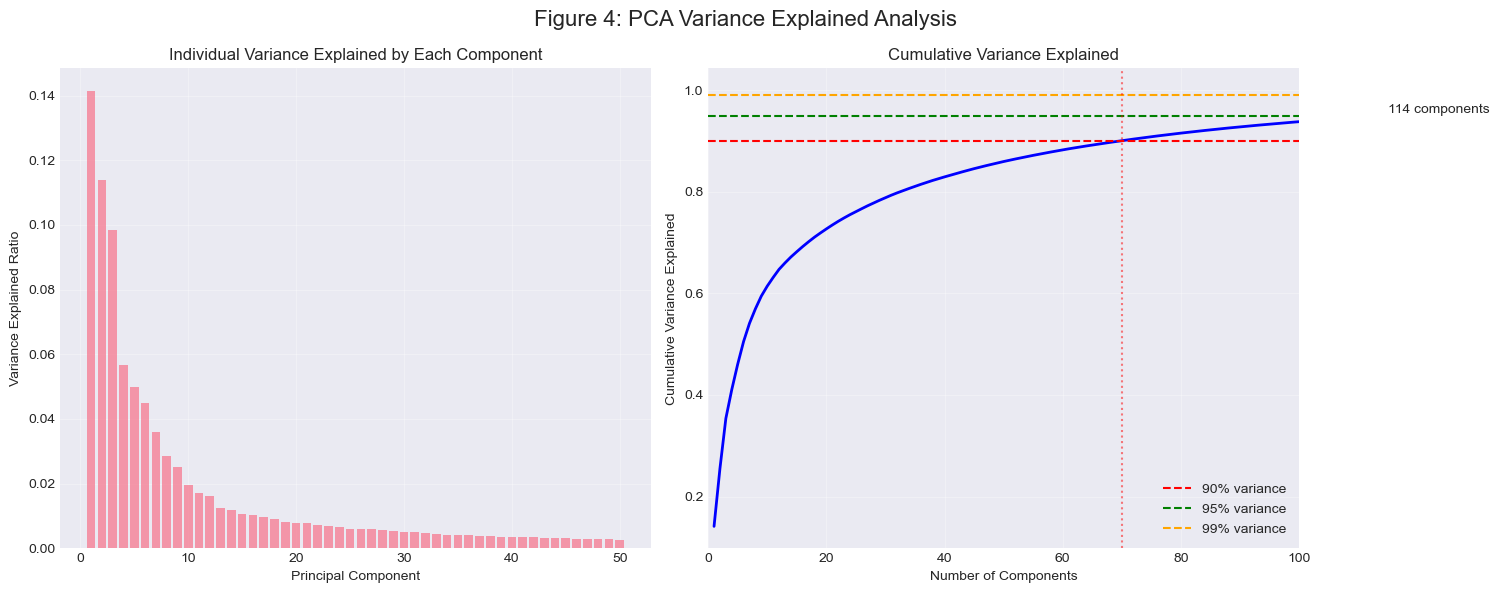


Top Principal Components Interpretation:

PC1 (Variance: 14.132%):
  - HipLeft_x_min: 0.087
  - AnkleRight_z_min: 0.086
  - HipRight_x_max: 0.085
  - FootRight_z_min: 0.085
  - AnkleRight_z_mean: 0.084

PC2 (Variance: 11.401%):
  - Neck_y_std: 0.096
  - SpineShoulder_y_std: 0.096
  - Head_y_std: 0.096
  - SpineMid_y_std: 0.095
  - SpineShoulder_y_max: 0.094

PC3 (Variance: 9.855%):
  - WristLeft_y_max: 0.107
  - ThumbLeft_y_max: 0.107
  - HandLeft_y_max: 0.107
  - HandTipLeft_y_max: 0.107
  - HandTipLeft_y_range: 0.106

PC4 (Variance: 5.664%):
  - leg_asymmetry: 0.123
  - KneeLeft_x_range: 0.122
  - KneeLeft_x_std: 0.121
  - AnkleLeft_x_range: 0.121
  - FootLeft_x_range: 0.121

PC5 (Variance: 4.995%):
  - WristRight_z_max: 0.103
  - ElbowRight_z_max: 0.102
  - ThumbRight_z_max: 0.096
  - HandRight_z_max: 0.096
  - WristRight_z_mean: 0.092


In [ ]:
# PCA Variance Explained Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Figure 4: PCA Variance Explained Analysis', fontsize=16)

# Individual variance explained
ax1 = axes[0]
n_show = min(50, len(pca.explained_variance_ratio_))
ax1.bar(range(1, n_show+1), pca.explained_variance_ratio_[:n_show], alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained Ratio')
ax1.set_title('Individual Variance Explained by Each Component')
ax1.grid(True, alpha=0.3)


ax2 = axes[1]
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-', linewidth=2)
ax2.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
ax2.axvline(x=n_components_90, color='r', linestyle=':', alpha=0.5)
ax2.axvline(x=n_components_95, color='g', linestyle=':', alpha=0.5)
ax2.axvline(x=n_components_99, color='orange', linestyle=':', alpha=0.5)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_title('Cumulative Variance Explained')
ax2.set_xlim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add text annotations
ax2.text(n_components_95 + 1, 0.95, f'{n_components_95} components', 
         verticalalignment='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_4_pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top principal components interpretation
print("\nTop Principal Components Interpretation:")
for i in range(min(5, n_components)):
    print(f"\nPC{i+1} (Variance: {pca.explained_variance_ratio_[i]:.3%}):")
    # Get top contributing features
    pc_weights = np.abs(pca.components_[i])
    top_indices = np.argsort(pc_weights)[-5:][::-1]
    
    all_feature_names = stat_feature_names + bio_feature_names
    for idx in top_indices:
        if idx < len(all_feature_names):
            print(f"  - {all_feature_names[idx]}: {pc_weights[idx]:.3f}")

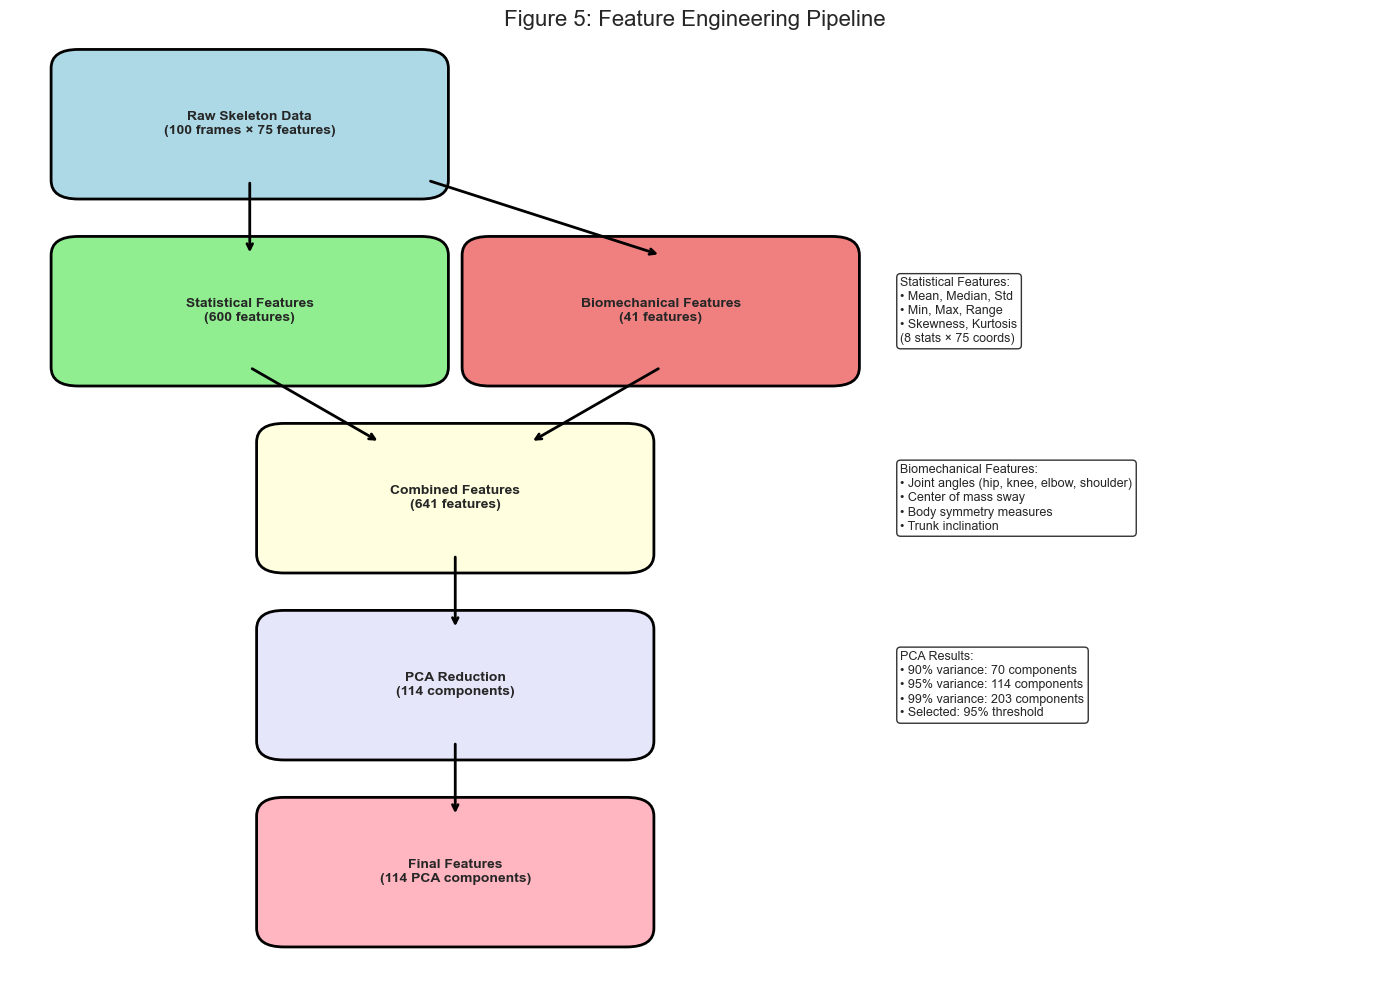

✓ Figure 5 saved to: ../../results/figures/feature_analysis/figure_5_feature_engineering_pipeline.png


In [ ]:
# Feature Engineering Pipeline
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Rectangle

fig, ax = plt.subplots(figsize=(14, 10))
fig.suptitle('Figure 5: Feature Engineering Pipeline', fontsize=16, y=0.98)


y_levels = [0.85, 0.65, 0.45, 0.25, 0.05]
box_width = 0.25
box_height = 0.12

# Raw Data
raw_data_box = FancyBboxPatch((0.05, y_levels[0]), box_width, box_height, 
                              boxstyle="round,pad=0.02", 
                              facecolor='lightblue', edgecolor='black', linewidth=2)
ax.add_patch(raw_data_box)
ax.text(0.175, y_levels[0]+0.06, 'Raw Skeleton Data\n(100 frames × 75 features)', 
        ha='center', va='center', fontsize=10, fontweight='bold')

# Statistical Features
stat_box = FancyBboxPatch((0.05, y_levels[1]), box_width, box_height,
                          boxstyle="round,pad=0.02",
                          facecolor='lightgreen', edgecolor='black', linewidth=2)
ax.add_patch(stat_box)
ax.text(0.175, y_levels[1]+0.06, 'Statistical Features\n(600 features)', 
        ha='center', va='center', fontsize=10, fontweight='bold')

# Biomechanical Features
bio_box = FancyBboxPatch((0.35, y_levels[1]), box_width, box_height,
                         boxstyle="round,pad=0.02",
                         facecolor='lightcoral', edgecolor='black', linewidth=2)
ax.add_patch(bio_box)
ax.text(0.475, y_levels[1]+0.06, 'Biomechanical Features\n(41 features)', 
        ha='center', va='center', fontsize=10, fontweight='bold')

# Combined Features
combined_box = FancyBboxPatch((0.2, y_levels[2]), box_width, box_height,
                              boxstyle="round,pad=0.02",
                              facecolor='lightyellow', edgecolor='black', linewidth=2)
ax.add_patch(combined_box)
ax.text(0.325, y_levels[2]+0.06, 'Combined Features\n(641 features)', 
        ha='center', va='center', fontsize=10, fontweight='bold')

# PCA
pca_box = FancyBboxPatch((0.2, y_levels[3]), box_width, box_height,
                         boxstyle="round,pad=0.02",
                         facecolor='lavender', edgecolor='black', linewidth=2)
ax.add_patch(pca_box)
ax.text(0.325, y_levels[3]+0.06, f'PCA Reduction\n({n_components} components)', 
        ha='center', va='center', fontsize=10, fontweight='bold')

# Final Features
final_box = FancyBboxPatch((0.2, y_levels[4]), box_width, box_height,
                           boxstyle="round,pad=0.02",
                           facecolor='lightpink', edgecolor='black', linewidth=2)
ax.add_patch(final_box)
ax.text(0.325, y_levels[4]+0.06, f'Final Features\n({n_components} PCA components)', 
        ha='center', va='center', fontsize=10, fontweight='bold')


arrow_props = dict(arrowstyle='->', lw=2, color='black')
# Raw to Statistical
ax.annotate('', xy=(0.175, y_levels[1]+0.12), xytext=(0.175, y_levels[0]),
            arrowprops=arrow_props)
# Raw to Biomechanical
ax.annotate('', xy=(0.475, y_levels[1]+0.12), xytext=(0.305, y_levels[0]),
            arrowprops=arrow_props)
# Statistical to Combined
ax.annotate('', xy=(0.27, y_levels[2]+0.12), xytext=(0.175, y_levels[1]),
            arrowprops=arrow_props)
# Biomechanical to Combined
ax.annotate('', xy=(0.38, y_levels[2]+0.12), xytext=(0.475, y_levels[1]),
            arrowprops=arrow_props)
# Combined to PCA
ax.annotate('', xy=(0.325, y_levels[3]+0.12), xytext=(0.325, y_levels[2]),
            arrowprops=arrow_props)
# PCA to Final
ax.annotate('', xy=(0.325, y_levels[4]+0.12), xytext=(0.325, y_levels[3]),
            arrowprops=arrow_props)

# Add feature details on the right
details_x = 0.65
ax.text(details_x, y_levels[1]+0.06, 'Statistical Features:\n• Mean, Median, Std\n• Min, Max, Range\n• Skewness, Kurtosis\n(8 stats × 75 coords)', 
        va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.text(details_x, y_levels[2]+0.06, 'Biomechanical Features:\n• Joint angles (hip, knee, elbow, shoulder)\n• Center of mass sway\n• Body symmetry measures\n• Trunk inclination', 
        va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.text(details_x, y_levels[3]+0.06, f'PCA Results:\n• 90% variance: {n_components_90} components\n• 95% variance: {n_components_95} components\n• 99% variance: {n_components_99} components\n• Selected: 95% threshold', 
        va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_5_feature_engineering_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure 5 saved to: {FIGURES_PATH / 'figure_5_feature_engineering_pipeline.png'}")

In [ ]:
# Save engineered features
print("Saving engineered features...")

# Save different feature sets
feature_sets = {
    'statistical': (X_train_stats, X_test_stats),
    'biomechanical': (X_train_bio, X_test_bio),
    'combined': (X_train_combined, X_test_combined),
    'pca': (X_train_pca, X_test_pca)
}

for feature_name, (train_features, test_features) in feature_sets.items():
    np.save(PROCESSED_PATH / f'X_train_{feature_name}.npy', train_features)
    np.save(PROCESSED_PATH / f'X_test_{feature_name}.npy', test_features)
    print(f"✓ Saved {feature_name} features: train {train_features.shape}, test {test_features.shape}")

# Save PCA model and scaler for later use
import pickle
with open(PROCESSED_PATH / 'pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)
with open(PROCESSED_PATH / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved PCA model and scaler")

# Create feature engineering summary
summary = {
    'n_statistical_features': X_train_stats.shape[1],
    'n_biomechanical_features': X_train_bio.shape[1],
    'n_combined_features': X_train_combined.shape[1],
    'n_pca_components': n_components,
    'pca_variance_explained': cumulative_variance[n_components-1],
    'feature_reduction_ratio': n_components / X_train_combined.shape[1]
}

# summary to save
with open(PROCESSED_PATH / 'feature_engineering_summary.txt', 'w') as f:
    f.write("FEATURE ENGINEERING SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")
    
    f.write("\n\nFeature Breakdown:\n")
    f.write(f"- Statistical features: {X_train_stats.shape[1]} (8 stats × 75 coordinates)\n")
    f.write(f"- Biomechanical features: {X_train_bio.shape[1]}\n")
    f.write(f"  * Joint angles: {len(angle_names) * 4} features\n")
    f.write(f"  * Center of mass sway: 3 features\n")
    f.write(f"  * Body symmetry: 2 features\n")
    f.write(f"- Total combined: {X_train_combined.shape[1]} features\n")
    f.write(f"- After PCA: {n_components} components ({cumulative_variance[n_components-1]:.1%} variance)\n")
    f.write(f"- Reduction ratio: {n_components / X_train_combined.shape[1]:.1%}\n")

print(f"\n✓ All features saved to: {PROCESSED_PATH}")
print("\n" + "="*50)
print("FEATURE ENGINEERING COMPLETE!")
print("="*50)
print(f"Original features: {X_train_combined.shape[1]}")
print(f"PCA components: {n_components}")
print(f"Reduction: {(1 - n_components/X_train_combined.shape[1])*100:.1f}%")
print(f"Ready for model training!")

Saving engineered features...
✓ Saved statistical features: train (2061, 600), test (516, 600)
✓ Saved biomechanical features: train (2061, 41), test (516, 41)
✓ Saved combined features: train (2061, 641), test (516, 641)
✓ Saved pca features: train (2061, 114), test (516, 114)
✓ Saved PCA model and scaler

✓ All features saved to: ../../data/processed

FEATURE ENGINEERING COMPLETE!
Original features: 641
PCA components: 114
Reduction: 82.2%
Ready for model training!
